In [1]:
import decode_eeg
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
np.random.seed(42)
%load_ext autoreload
%autoreload 2

In [9]:
def plot_beh_ss_acc(ss_acc,experiment_name = '', savefig=False, fig_dir = False):
    ax = plt.subplot(111)
    ax.violinplot(ss_acc,showmeans=True, showextrema=True)
    # y=np.repeat([1,2,3,4],20,0)
    # y = np.vstack((y,[1,2,3,4]))
    # ax.scatter(y,ss_acc,alpha=.25)
    plt.xlabel('Set Size')
    plt.ylabel('Accuracy')

    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    # plt.title('Behavioral Accuracy for Each Set Size\nColor')

    ax.set_yticks(np.arange(.5,1.01,.1))
    ax.set_xticks(np.arange(1,5,1))

    if savefig:
        for file_format in ['pdf','png']:
            title = experiment_name + '_beh_ss_acc' + '.' + file_format
            if fig_dir:
                title = fig_dir / title
            plt.savefig(title, format='pdf',bbox_inches='tight',dpi=1000)
            plt.savefig(title, format='png', bbox_inches='tight',dpi=1000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


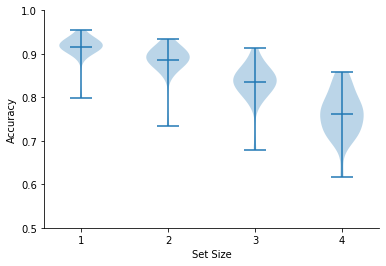

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


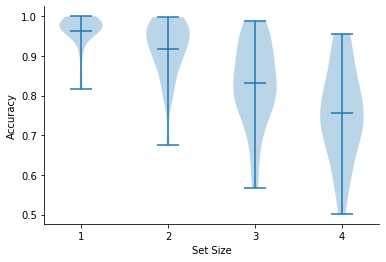

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


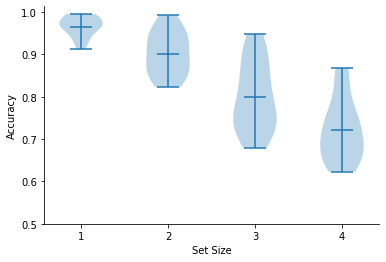

In [14]:
output_dir = Path('./output')
fig_dir = output_dir / 'figures' / 'behavior'

experiment_names = ['1801','1901','1902']
for experiment_name in experiment_names:
    
    data_dir = f'./data/{experiment_name}'
    exp = decode_eeg.Experiment(experiment_name,data_dir,test=False)

    labels = [1,2,3,4]
    num_labels = len(labels)
    acc = np.zeros(exp.nsub)
    rt = np.zeros(exp.nsub)
    ss_acc = np.zeros((exp.nsub,num_labels))
    ss_rt = np.zeros((exp.nsub,num_labels))
    ss_acc_se = np.zeros((exp.nsub,num_labels))
    ss_rt_se = np.zeros((exp.nsub,num_labels))
    
    for isub in range(exp.nsub):
        print(isub)
        # Load subject's behavior data
        behavior = exp.load_behavior(isub)
        header = list(behavior.keys())
        # acc[isub] = np.mean(behavior['ACC'])
        # rt[isub] = np.mean(behavior['RT'])
        
        # calculate acc and reaction time for each set size condition
        for iss,iss_name in enumerate(labels):
            
            iss_idx = behavior['SetSize'] == int(iss_name)
            ss_acc[isub,iss] = np.mean(behavior['ACC'][iss_idx])
            ss_rt[isub,iss] = np.mean(behavior['RT'][iss_idx])
            
            std = np.std(behavior['ACC'][iss_idx])
            ss_acc_se[isub,iss] = std/len(behavior['ACC'][iss_idx])
            std = np.std(behavior['RT'][iss_idx])
            ss_rt_se[isub,iss] = std/len(behavior['RT'][iss_idx])

    plot_beh_ss_acc(ss_acc, savefig=True,experiment_name = experiment_name, fig_dir=fig_dir)
    plt.show()